<a href="https://colab.research.google.com/github/victorcharpentier/Anapix/blob/main/VPC_Global_Clustering_ISIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMDhiZDBkMC1jMjhkLTQ0YjgtYmVlYS02Y2E0ZThmNDY3NjIifQ=="

!pip install pytorch-lightning

import psutil
import ipywidgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler, SGD

import os

import albumentations as A
from albumentations.pytorch import ToTensor #ToTensorV2, ToTensor

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning import loggers
from pytorch_lightning.metrics.functional import accuracy, auroc, recall, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from collections import OrderedDict
from sklearn import manifold
from pandas import DataFrame
from copy import deepcopy

import sklearn as sk
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import AgglomerativeClustering

     |████████████████████████████████| 819kB 7.4MB/s 
     |████████████████████████████████| 10.6MB 16.1MB/s 
     |████████████████████████████████| 829kB 43.9MB/s 
     |████████████████████████████████| 235kB 43.3MB/s 
     |████████████████████████████████| 645kB 43.5MB/s 
     |████████████████████████████████| 122kB 60.9MB/s 
     |████████████████████████████████| 1.3MB 48.4MB/s 
     |████████████████████████████████| 296kB 48.6MB/s 
     |████████████████████████████████| 143kB 49.5MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=fb8916c45b2b5ebaf5da3922357cca1a35583fa7ad40ca526b7f766387ce1b41
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Succ

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My Drive/Anapix/

/content/gdrive/My Drive/Anapix


In [4]:
images_path = 'mix_autocropped_224px/'

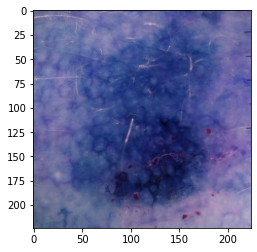

In [ ]:
image = cv2.imread("mix_autocropped_224px/ISIC_0351666.jpeg")
plt.imshow(image)

In [ ]:
class ResnetMulti9cl(LightningModule):  #récupération de notre modèle
        def __init__(self, hparams):
          super().__init__()
          self.save_hyperparameters(hparams)
          self.batch_size = hparams['batch_size']
          self.lr = hparams['lr']
          self.workers = hparams['workers']
          self.test_results = []
          self.test_labels = []
          
          self.model = models.resnet50(pretrained=True)
          self.num_features = self.model.fc.in_features
          self.model.fc = torch.nn.Linear(self.num_features, 512)

        
        def forward(self, x):
          x = self.model(x)
          return x

ckpt_path_198_TES_5 = 'siamese/TES-5/checkpoints/epoch=9-step=11739.ckpt'
model_198_TES_5 = ResnetMulti9cl.load_from_checkpoint(checkpoint_path=ckpt_path_198_TES_5) #récupération d'un checkpoint à 0.16 d'erreur moyenne avec le concensus expert sur la base test
model_198_TES_5.freeze()  #blocage des neurones aléatoires

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [ ]:
data_isic=pd.read_csv('data_isic_skn4.csv', sep=',') 
print(data_isic)

                    path  ... multilabel3
0       ISIC_0053467.jpg  ...           1
1       ISIC_0053522.jpg  ...           1
2       ISIC_0053523.jpg  ...           1
3       ISIC_0053569.jpg  ...           1
4       ISIC_0053663.jpg  ...           1
...                  ...  ...         ...
16734  ISIC_0030060.jpeg  ...           2
16735  ISIC_0026105.jpeg  ...           2
16736  ISIC_0026798.jpeg  ...           0
16737  ISIC_0027478.jpeg  ...           0
16738  ISIC_0029172.jpeg  ...           2

[16739 rows x 10 columns]


In [ ]:
data_isic=pd.read_csv('data_isic_skn4.csv', sep=',') 
model_X=model_198_TES_5.model #on récupère le modèle de machine learning

columns=['path','diagnosis2']
for k in range(1,513):
  columns.append("feature "+str(k))
data_isic_predicteurs = pd.DataFrame(None, columns=columns) #on initie notre dataset avec le noms des différentes colonnes
compteur=0

for index, row in data_isic.iterrows():
      img_name = images_path + data_isic["path"][index]
      print(img_name)
      
      if not os.path.isfile(img_name):
          img_name=img_name[0:len(img_name)-1]
          img_name=img_name+"eg"
          print(img_name)
          if not os.path.isfile(img_name):
            print('not found', img_name)
            raise IOError(f'The following file was not found: {img_name}')

      image = cv2.imread(img_name)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = image/255
      image = ToTensor()(image=image)['image'].float()
      image = image.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle

      predicteurs = model_X(image)

      ligne=[data_isic["path"][index],data_isic["diagnosis2"][index]] #on initie la ligne avec les informations de l'image
      for i in range(len(predicteurs[0])):
        ligne.append(float(predicteurs[0][i])) #et on y rajouter toutes les features
      ligne=[ligne]
      nouvelle_ligne=pd.DataFrame(ligne, columns = columns) #on la formate

      data_isic_predicteurs=data_isic_predicteurs.append(nouvelle_ligne,ignore_index=True) #et on la rajouter à notre dataframe patients
      compteur=compteur+1
      print(compteur/16739)

data_isic_predicteurs.to_csv('data_isic_predicteurs.csv', index=False) #on sauvegarde notre fichier

In [11]:
data_isic_predicteurs=pd.read_csv('data_isic_predicteurs.csv', sep=',') 
#print(data_isic_predicteurs)
liste_labels=[]
for labels in data_isic_predicteurs["diagnosis2"]:
  if labels not in liste_labels:
    liste_labels.append(labels)
    print(labels)


benign keratosis
squamous cell carcinoma
actinic keratosis
lentigo
dermatofibroma
melanoma
vascular lesion
basal cell carcinoma
nevus


      feature 1  feature 2  feature 3  ...  feature 510  feature 511  feature 512
0      0.151360  -0.029531   0.004448  ...     0.053967    -0.039863     0.096489
1      0.121237   0.016108  -0.004139  ...     0.091396    -0.104390     0.082053
2      0.102003  -0.033277  -0.063280  ...     0.069205    -0.077195     0.116246
3      0.106886   0.009912  -0.015423  ...     0.070268    -0.014719     0.042174
4      0.128764  -0.047873  -0.014693  ...     0.069665    -0.100577     0.094940
...         ...        ...        ...  ...          ...          ...          ...
1995   0.124736  -0.044436  -0.025768  ...     0.043728    -0.060842     0.089071
1996   0.101314  -0.085200  -0.017715  ...     0.075295    -0.076222     0.064775
1997   0.121995  -0.059819  -0.050963  ...     0.090856    -0.066824     0.057433
1998   0.123976  -0.009629  -0.015089  ...     0.055170    -0.044553     0.073225
1999   0.135663  -0.066418   0.023022  ...     0.048096    -0.046406     0.030942

[2000 rows x 51

No handles with labels found to put in legend.


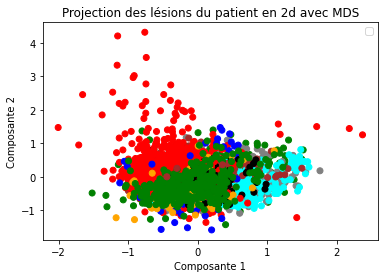

'nb_cluster_minimum=40\nK = range(nb_cluster_minimum,70) #test de nb_cluster_minimum à 5 clusters\nfor o in K:\n  clustering = AgglomerativeClustering(n_clusters=o).fit(X)\n  labels = clustering.labels_\n  silhouette_vals.append(np.mean(silhouette_score(X,labels))) #pour un certains nombre de clusters on calcule la silhouette de notre clustering\n\n\nidx_max=0\nmax=-1\nfor k in range(len(silhouette_vals)): #on retrouve le nombre de clusters maximisant la silhouette - nb_cluster_minimum\n  if silhouette_vals[k]>max:\n    max=silhouette_vals[k]\n    idx_max=k\n\nprint(idx_max+nb_cluster_minimum)\nclustering = AgglomerativeClustering(n_clusters=idx_max+nb_cluster_minimum)    #l\'on utilise le nombre de clusters maximisant la silhouette\nprediction = clustering.fit_predict(X)\n\n    #comparaison entre le vrai clustering et la prediction au niveau des VPC\n    #premièrement on regarde le nombre de VPC repérés dans des clusters uniques\n\nindex_VPC=[] #dans cette liste apparaitront les index

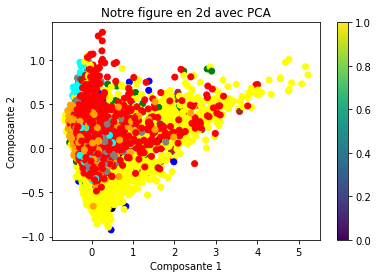

In [5]:
nb_VPC_identifiés_par_cluster_unique=0
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster=0
nb_VPC_total=0 #nombre de lésions prédites comme des VPC dans un cluster unique ou dans des petits clusters
nb_faux_VPC_unique=0
nb_faux_VPC_petit_cluster=0
nb_images=0 #nombres d'images dans notre dataset
nb_testés_total=0 #initialisation des données statistiques

data_isic_predicteurs=pd.read_csv('data_isic_predicteurs.csv', sep=',')  #on lit notre dataset d'entrainement

Y = DataFrame(data_isic_predicteurs['diagnosis2'], columns = ['diagnosis2']) #on récupère le label de l'image pour faire de la visualisation
X = data_isic_predicteurs.drop(['path','diagnosis2'],axis=1) #on récupère les features de notre images
X1= X[:5000]
print(X1)

Y['diagnosis2'][Y['diagnosis2'] == "benign keratosis"] = "green"
Y['diagnosis2'][Y['diagnosis2'] == "squamous cell carcinoma" ] = "grey"
Y['diagnosis2'][Y['diagnosis2'] == "actinic keratosis" ] = "cyan"
Y['diagnosis2'][Y['diagnosis2'] == "lentigo" ] = "brown"
Y['diagnosis2'][Y['diagnosis2'] == "dermatofibroma" ] = "black"
Y['diagnosis2'][Y['diagnosis2'] == "melanoma" ] = "red"
Y['diagnosis2'][Y['diagnosis2'] == "vascular lesion" ] = "blue"
Y['diagnosis2'][Y['diagnosis2'] == "basal cell carcinoma" ] = "orange"
Y['diagnosis2'][Y['diagnosis2'] == "nevus" ] = "yellow"


plt.show()
y=[]
for i ,row in Y.iterrows():
  y.append(row[0])  #on créer une liste de couleur ou la couleur rouge décrit les VPC et le jaune les autres 

y1=y[:5000]

nb_images=nb_images+len(y)

mds = manifold.MDS(n_components=2)
projectedMDS = mds.fit_transform(X1)
plt.scatter(projectedMDS[:, 0], projectedMDS[:, 1], c=y1)
plt.title("Projection des lésions du patient en 2d avec MDS")
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.legend()
plt.show() #on visualise les lésions cutanées du patient avec mds, les VPC y sont situés en rouge '''

pca = PCA(2)  
projectedPCA = pca.fit_transform(X)
plt.scatter(projectedPCA[:, 0], projectedPCA[:, 1],
            c=y)
plt.title("Notre figure en 2d avec PCA")
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.colorbar();
    
'''nb_cluster_minimum=40
K = range(nb_cluster_minimum,70) #test de nb_cluster_minimum à 5 clusters
for o in K:
  clustering = AgglomerativeClustering(n_clusters=o).fit(X)
  labels = clustering.labels_
  silhouette_vals.append(np.mean(silhouette_score(X,labels))) #pour un certains nombre de clusters on calcule la silhouette de notre clustering


idx_max=0
max=-1
for k in range(len(silhouette_vals)): #on retrouve le nombre de clusters maximisant la silhouette - nb_cluster_minimum
  if silhouette_vals[k]>max:
    max=silhouette_vals[k]
    idx_max=k

print(idx_max+nb_cluster_minimum)
clustering = AgglomerativeClustering(n_clusters=idx_max+nb_cluster_minimum)    #l'on utilise le nombre de clusters maximisant la silhouette
prediction = clustering.fit_predict(X)

    #comparaison entre le vrai clustering et la prediction au niveau des VPC
    #premièrement on regarde le nombre de VPC repérés dans des clusters uniques

index_VPC=[] #dans cette liste apparaitront les index des VPC
nb_testés=0 #nombre de lésions prédites comme des VPC dans un cluster unique
nb_clusters=len(np.unique(prediction)) #nombre de clusters dans la prediction

liste_clusters=[] #dans cette liste apparaitront les index des images par cluster pour les repérer plus facilement an allant regarder nos images
for e in range(nb_clusters):
  liste_clusters.append([])

for a in range(len(y)):
  if y[a]=="red" or y[a]=="orange":
    index_VPC.append(a) #index des VPC
  liste_clusters[prediction[a]].append(a)
    
clusters_unique=[]
for g in range (nb_clusters):
  if len(liste_clusters[g])==1:
    nb_testés=nb_testés+1
    nb_testés_total=nb_testés_total+1
    clusters_unique.append(liste_clusters[g][0]) #on récupère les index de clusters uniques
    
nb_trouvés_unique=0
for l in index_VPC:
  if l in clusters_unique:
    nb_trouvés_unique=nb_trouvés_unique+1 #on comptabilise les clusters uniques étant réellement des VPC 
    
nb_VPC_identifiés_par_cluster_unique=nb_VPC_identifiés_par_cluster_unique + nb_trouvés_unique #nombre total de VPC trouvés par clusters contenant un seul individu
nb_faux_VPC_unique=nb_faux_VPC_unique+len(clusters_unique)-nb_trouvés_unique #nombres total d'images apparaissant dans des clusters uniques sans être un VPC
  
print("Le clustering unique trouve "+str(len(clusters_unique))+ " unique dont "+str(nb_trouvés_unique)+" sur "+str(len(index_VPC))+ " VPC et " + str(len(clusters_unique)-nb_trouvés_unique)+ " faux positifs")

#dans un second temps on identifie les clusters possédant moins de x d'individus et on regarde le nombre de VPC à l'intérieur

nb_VPC_total = nb_VPC_total + len(index_VPC)

nb_trouvés_petit_cluster=0
nb_cas_petit_cluster=0 #le nombre d'images que l'on va tester en regardant les petit clusters
liste_index_petit_clusters=[]
nb_individus_max=6

for r in range(len(liste_clusters)):
  if 1<len(liste_clusters[r])<=nb_individus_max: #pour les clusters allant jusqu'à nb_individus_max individus on regarde s'il s'y trouve des VPC
    nb_cas_petit_cluster=nb_cas_petit_cluster+len(liste_clusters[r]) 
    nb_testés=nb_testés+len(liste_clusters[r]) #le nombre d'images testés augmente et permet de voir les nombre de faux positifs pour un patient
    nb_testés_total=nb_testés_total+len(liste_clusters[r])
    liste_index_petit_clusters.append(r) #on rajoute tout les petits clusters dans une liste
    
for g in liste_index_petit_clusters:
  for h in liste_clusters[g]:
    if h in index_VPC:          #on regarde s'il y a des VPC dans les petits clusters
      nb_trouvés_petit_cluster=nb_trouvés_petit_cluster+1

nb_faux_VPC_petit_cluster = nb_faux_VPC_petit_cluster + nb_cas_petit_cluster - nb_trouvés_petit_cluster #le nombre de faux positifs trouvés dans les petits clusters se voit augmenter 
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster = nb_VPC_identifiés_par_cluster_unique_et_petit_cluster + nb_trouvés_unique +nb_trouvés_petit_cluster #le nombre de vrai positif dans les clusters uniques et petits clusters

print("Le clustering unique et petits clusters trouve "+str(nb_trouvés_unique+nb_trouvés_petit_cluster)+" VPC sur "+str(len(index_VPC))+ " dont " + str(nb_testés-nb_trouvés_unique-nb_trouvés_petit_cluster)+ " faux positifs")

print("la liste des clusters est : "+str(liste_clusters))
print("les index des VPC sont : "+str(index_VPC))

plt.figure(figsize=(16,8))
plt.scatter(projectedMDS[: , 0] , projectedMDS[: , 1] , c = prediction)
plt.title("Projection des lésions du patient en 2d avec MDS avec AgglomerativeClustering pour "+str(idx_max+2)+" clusters")
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.legend()
plt.show() #cette fois on affiche la prediction du clustering jierarchique ayant le meilleur score en silhouette 

  
rappel_cluster_unique=(nb_VPC_identifiés_par_cluster_unique/nb_VPC_total)*100
precision_cluster_unique=((nb_VPC_identifiés_par_cluster_unique)/(nb_faux_VPC_unique+nb_VPC_identifiés_par_cluster_unique))*100 #définition des scores
f1_cluster_unique=2*(rappel_cluster_unique*precision_cluster_unique)/(rappel_cluster_unique+precision_cluster_unique)

rappel_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/nb_VPC_total)*100
precision_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/(nb_faux_VPC_unique+nb_faux_VPC_petit_cluster+nb_VPC_identifiés_par_cluster_unique_et_petit_cluster))*100
f1__unique_petit_cluster=2*(rappel_unique_petit_cluster*precision_unique_petit_cluster)/(rappel_unique_petit_cluster+precision_unique_petit_cluster)

fp=nb_testés_total-nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
vp=nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
fn = nb_VPC_total- vp
vn= nb_images -fp-vp-fn

print("Pour les clusters uniques, rappel : "+ str(rappel_cluster_unique) + " % précision : "+str(precision_cluster_unique) + " % et f1 = "+str(f1_cluster_unique))
print("Pour les clusters uniques + petit cluster , rappel : "+ str(rappel_unique_petit_cluster) + " % précision : "+str(precision_unique_petit_cluster) + " % et f1 = "+str(f1__unique_petit_cluster))
print("Pour les clusters uniques + petit cluster , spécificité : "+ str((vn)*100/(vn+fp))+ " % ")'''